In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from autograd import elementwise_grad, grad
import autograd.numpy as np
import scipy
from scipy.optimize import minimize

In [2]:
n = 1
gamma = 0.2

In [3]:
# betas = np.random.beta(7,1,size=1000)
betas = np.random.exponential(scale=5,size=1000)

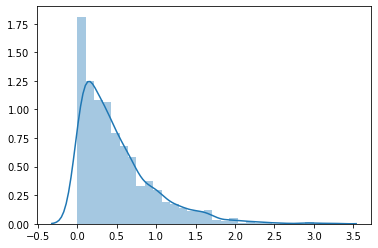

In [4]:
sns.distplot(betas)

In [5]:
def sal(par,y):
    assert len(par)>=4, "not enough params"
    return par[0]+par[1]*np.sinh(par[2]*np.arcsinh(y) + par[3])

In [6]:
def sal_comp(par,y,n):
    assert len(par)>=4*n, "not enough params"
    comp = y
    for i in range(0,n):
        comp = sal(par[4*i:],comp)
    return comp

In [7]:
# http://stackoverflow.com/questions/45599524/partial-derivative-using-autograd

In [8]:
d_sal = elementwise_grad(sal_comp,1)

In [9]:
d_sal

<function autograd.wrap_util.unary_to_nary.<locals>.nary_operator.<locals>.nary_f(*args, **kwargs)>

In [10]:
def cov_kernel(gamma,x):
    return np.exp(-gamma*np.abs(x))

In [11]:
par = np.random.rand(4*n)
phi_y = sal_comp(par,betas,n)
phi_y = phi_y[np.newaxis].reshape(-1,1)
t_phi_y = np.transpose(phi_y)

print(phi_y.shape,t_phi_y.shape)

(1000, 1) (1, 1000)


In [12]:
phi_y

array([[1.10602526],
       [1.08057714],
       [1.25674129],
       [1.08783994],
       [1.13080121],
       [1.06875271],
       [1.07056793],
       [1.12079839],
       [1.11664561],
       [1.06853132],
       [1.31596796],
       [1.24813256],
       [1.19399408],
       [1.2070077 ],
       [1.08659048],
       [1.11596707],
       [1.42691007],
       [1.07989086],
       [1.07176341],
       [1.24386197],
       [1.09998375],
       [1.24237019],
       [1.11164449],
       [1.06807004],
       [1.07702066],
       [1.17422668],
       [1.2739698 ],
       [1.11139361],
       [1.22554634],
       [1.06564142],
       [1.14748042],
       [1.21172926],
       [1.07872009],
       [1.2525302 ],
       [1.18722323],
       [1.14907817],
       [1.06587683],
       [1.08426209],
       [1.16809807],
       [1.13903045],
       [1.10868706],
       [1.12678412],
       [1.48761415],
       [1.20262506],
       [1.1046996 ],
       [1.08897886],
       [1.07616614],
       [1.125

In [13]:
def nllf(par):
    phi_y = sal_comp(par,betas,n)
    phi_y = phi_y[np.newaxis].reshape(-1,1)
    t_phi_y = np.transpose(phi_y)
    
    cov_xx = cov_kernel(gamma,np.log(np.exp(phi_y) @ np.exp(-(t_phi_y))))
    gaussian_params = 0.5 * (t_phi_y) @ np.linalg.inv(cov_xx) @ phi_y

    
    return  0.5 * np.log(np.linalg.det(cov_xx)) + gaussian_params - sum(np.log(d_sal(par,betas,n)))

In [14]:
nllf(np.random.rand(4*n))

/home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


array([[-inf]])

In [15]:
res = minimize(nllf, np.random.rand(4*n), method='SLSQP')
while res.success == False:
    try:
        rand = np.random.uniform(low=-2, high=2, size=(4*n, 1))
        res = minimize(nllf, rand , method='SLSQP')
        print(rand)
    except:
        pass

/home/chen/work/venv/lib/python3.6/site-packages/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/home/chen/work/venv/lib/python3.6/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


KeyboardInterrupt: 

In [ ]:
res

In [ ]:
res.x

In [ ]:
transformed_betas = sal_comp(res.x,betas,n)

In [ ]:
sns.distplot(transformed_betas)